# Defender Positions

We want to engineer features that consider the positioning of defenders near the kick. We think this will improve our expected goals models.

In [1]:
# Add this so we can import our haxml code from outside the notebooks folder.
import sys
sys.path.append("../")

from haxml.prediction import (
    generate_rows_demo
)
from haxml.utils import (
    load_match,
    inflate_match,
    get_stadiums,
    get_matches_metadata,
    to_clock
)
from haxml.viz import (
    plot_stadium,
    zoom_stadium,
    plot_positions
)
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import json
import pandas as pd

In [2]:
stadiums = get_stadiums("../data/stadiums.json")
metadata = get_matches_metadata("../data/matches_metadata.csv")

In [3]:
meta = metadata[218]
meta

{'match_id': '-MPQajNbaLoevAcO0K-e',
 'stadium': 'NAFL Official Map v1',
 'time': 245.3,
 'kicks_red': 60,
 'kicks_blue': 65,
 'score_red': 3,
 'score_blue': 2,
 'scored_goals_red': 3,
 'scored_goals_blue': 2}

In [4]:
key = meta["match_id"]
infile = "../data/packed_matches/{}.json".format(key)
stadium = stadiums[meta["stadium"]]
match = load_match(infile)
row_gen = generate_rows_demo(match, stadium)
df = pd.DataFrame(row_gen)
df["match"] = key

In [5]:
df.query("ag == 1").head()

,ag,index,time,x,y,goal_x,goal_y,goal_distance,goal_angle,team,stadium,match
40,1,40,95.9,418.0,-282.0,700,0,398.808225,0.785398,red,NAFL Official Map v1,-MPQajNbaLoevAcO0K-e
61,1,61,127.6,-687.0,-19.0,-700,0,23.021729,0.600050,blue,NAFL Official Map v1,-MPQajNbaLoevAcO0K-e
78,1,78,166.0,406.0,231.0,700,0,373.894370,0.904827,red,NAFL Official Map v1,-MPQajNbaLoevAcO0K-e
80,1,80,169.4,-207.0,-288.0,-700,0,570.957967,1.042092,blue,NAFL Official Map v1,-MPQajNbaLoevAcO0K-e
124,1,124,245.3,604.0,-252.0,700,0,269.666461,0.363979,red,NAFL Official Map v1,-MPQajNbaLoevAcO0K-e


In [6]:
pd.DataFrame(match["positions"]).head(10)

,type,time,x,y,playerId,name,team
0,player,0.0,-200.0,0.0,61.0,Player 82,red
1,player,0.0,-200.0,55.0,51.0,Player 151,red
2,player,0.0,-200.0,-55.0,53.0,Player 170,red
3,player,0.0,-200.0,110.0,58.0,Player 106,red
4,player,0.0,200.0,0.0,62.0,Player 55,blue
5,player,0.0,200.0,55.0,54.0,Player 171,blue
6,player,0.0,200.0,-55.0,57.0,Player 111,blue
7,player,0.0,200.0,110.0,59.0,Player 172,blue
8,ball,0.0,0.0,0.0,NaN,None,None
9,player,0.3,11.0,-11.0,61.0,Player 82,red


Pseudocode plan:

- Given a kick, find the positions of players at the time the ball was kicked
- Estimate time ball was kicked as three seconds earlier than the result time
- Always find positions before the kicked time, not after

In [8]:
def get_positions_at_time(positions, t):
    """
    Return a list of positions (dicts) closest to, but before time t.
    """
    # Assume positions list is already sorted.
    # frame is a list of positions (dicts) that have the same timestamp.
    frame = []
    time = 0.0
    for pos in positions:
        if pos["time"] > t:
            break
        if pos["time"] == time:
            frame.append(pos)
        else:
            frame = []
            time = pos["time"]
    return frame

In [26]:
example = df.query("ag == 1").to_dict(orient="records")[1]
example

{'ag': 1,
 'index': 61,
 'time': 127.6,
 'x': -687.0,
 'y': -19.0,
 'goal_x': -700,
 'goal_y': 0,
 'goal_distance': 23.021728866442675,
 'goal_angle': 0.6000502134017536,
 'team': 'blue',
 'stadium': 'NAFL Official Map v1',
 'match': '-MPQajNbaLoevAcO0K-e'}

In [28]:
offset = 2 # seconds
print("Get positions at {}.".format(example["time"] - offset))
r1 = get_positions_at_time(match["positions"], example["time"] - offset)
pd.DataFrame(r1)

Get positions at 125.6.


,type,time,x,y,playerId,name,team
0,player,125.6,-432.0,165.0,51.0,Player 151,red
1,player,125.6,489.0,117.0,53.0,Player 170,red
2,player,125.6,-394.0,3.0,58.0,Player 106,red
3,player,125.6,-380.0,135.0,57.0,Player 111,blue
4,player,125.6,-417.0,-231.0,55.0,Player 96,blue
5,player,125.6,-478.0,66.0,63.0,Player 14,blue
6,player,125.6,600.0,50.0,54.0,Player 171,blue
7,ball,125.6,-442.0,-262.0,NaN,None,None


In [29]:
def get_positions_in_range(positions, start, end):
    """
    Return a list of positions (dicts) between start and end (inclusive).
    """
    assert start <= end, "Time `start` must be before `end`."
    
    def is_in_time_range(pos):
        return pos["time"] >= start and pos["time"] <= end
    
    return list(filter(is_in_time_range, positions))

In [31]:
print("Get positions between {} and {}.".format(sample["time"] - offset, sample["time"]))
r2 = get_positions_in_range(match["positions"], sample["time"] - offset, sample["time"])
pd.DataFrame(r2)

Get positions between 125.6 and 127.6.


,type,time,x,y,playerId,name,team
0,player,125.6,-201.0,-46.0,61.0,Player 82,red
1,player,125.6,-432.0,165.0,51.0,Player 151,red
2,player,125.6,489.0,117.0,53.0,Player 170,red
3,player,125.6,-394.0,3.0,58.0,Player 106,red
4,player,125.6,-380.0,135.0,57.0,Player 111,blue
...,...,...,...,...,...,...,...
67,player,127.4,-492.0,-97.0,57.0,Player 111,blue
68,player,127.4,-475.0,-230.0,55.0,Player 96,blue
69,player,127.4,-685.0,-19.0,63.0,Player 14,blue
70,player,127.4,301.0,41.0,54.0,Player 171,blue


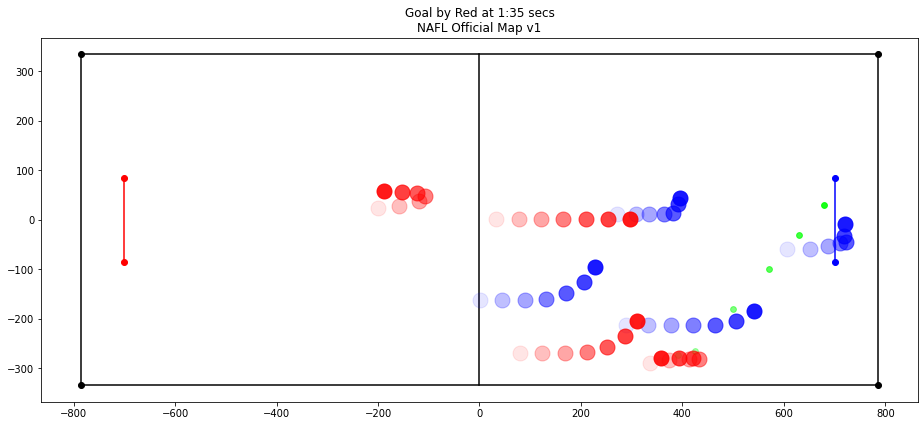

In [33]:
offset = 2
show_trail = True
goals = df.query("ag == 1").to_dict(orient="records")
goal = goals[0]
if show_trail:
    before_goal = get_positions_in_range(match["positions"], goal["time"] - offset, goal["time"])
else:
    before_goal = get_positions_at_time(match["positions"], goal["time"] - offset)
fig, ax = plot_positions(before_goal, stadium)
w, h = zoom_stadium(stadium["bounds"])
goal_team = "Red" if goal["team"] == "red" else "Blue"
goal_clock = to_clock(goal["time"])
title = "Goal by {} at {} secs\n{}".format(goal_team, goal_clock, stadium["stadium"])
ax.set_title(title)
fig.set_size_inches(w, h)
fig

The next step is to take the data from the frame before the kick and quantify defender positioning, like distance between defender in ball, number of defenders in the goal area, and other heuristics.

Write a method that takes in a match and stadium and produces the new features, then we can easily integrate it into the model training process.